In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

import lightgbm as lgb
import requests

%matplotlib inline

In [16]:
df_transactions = pd.read_csv('transactions.csv')
df_transactions['dates'] = pd.to_datetime(df_transactions['dates'])
df_transactions.tail()

,dates,SKU,user,price
1334255,2019-04-21,16663,20223,2240.0
1334256,2019-04-21,16663,25555,2240.0
1334257,2019-04-21,16663,47340,2240.0
1334258,2019-04-21,16663,23762,2240.0
1334259,2019-04-21,16663,48007,2240.0


In [17]:
df_wholesale_trade_table = pd.read_csv('wholesale_trade_table.csv')
df_wholesale_trade_table = df_wholesale_trade_table.sort_values(by=['year', 'month', 'week_num'])
df_wholesale_trade_table.tail()

,SKU,year,week_num,month,cost_price
60898,98842,2019,52,12,1206.0
60976,99266,2019,52,12,1632.0
61079,99310,2019,52,12,355.0
61181,99974,2019,52,12,2900.0
61251,99996,2019,52,12,692.0


In [18]:
df_promo = pd.read_csv('promo_df.csv')
df_promo.tail()

,SKU,week_num,year,discount
2337,35645,52,2019,0.15
2338,81314,52,2019,0.05
2339,75661,52,2019,0.05
2340,38664,52,2019,0.05
2341,47952,52,2019,0.10


In [19]:
df_sales = pd.read_csv('sales_plan.csv')
df_sales.tail()

,SKU,year,month,plan,back_bonus
12207,99996,2019,8,190.0,140000
12208,99996,2019,9,150.0,100000
12209,99996,2019,10,150.0,200000
12210,99996,2019,11,150.0,100000
12211,99996,2019,12,150.0,100000


In [20]:
df_canc = pd.read_csv('canc_df.csv')
df_canc.tail()

,year,week_num,SKU,ret_net_1_price,ret_net_2_price,ret_net_3_price
10319,2019,52,97659,3409.219608,3394.456244,3434.336572
10320,2019,52,98346,1632.598644,1710.327024,1638.673052
10321,2019,52,98642,1498.441016,1520.235649,1481.583880
10322,2019,52,98774,1649.812737,1638.274072,1725.167364
10323,2019,52,99974,3369.132504,3343.880679,3370.393064


# Data preparation

In [21]:
def date_to_datetime(df):
#     df['year'] = df.dates.dt.year
#     df['month'] = df.dates.dt.month
    df['quarter_of_year'] = df.dates.dt.quarter
#     df['week_num'] = df.dates.dt.isocalendar().week.astype(int)
    df['day_of_year'] = df.dates.dt.dayofyear
    df['day_of_month'] = df.dates.dt.day
    df['day_of_week'] = df.dates.dt.dayofweek
    df["is_wknd"] = df.dates.dt.weekday // 4
    df['is_month_start'] = df.dates.dt.is_month_start.astype(int)
    df['is_month_end'] = df.dates.dt.is_month_end.astype(int)
    df = df.drop(columns=['dates'])
    
    return df

In [22]:
df_transactions['dates'] = pd.to_datetime(df_transactions['dates'])
df_transactions['year'] = df_transactions.dates.dt.year
df_transactions['month'] = df_transactions.dates.dt.month
df_transactions['week_num'] = df_transactions.dates.dt.isocalendar(
).week.astype(int)
df_transactions = df_transactions.sort_values(by=['year', 'month', 'week_num'])


df_wholesale_trade_table = pd.read_csv('wholesale_trade_table.csv')
df_wholesale_trade_table = df_wholesale_trade_table.sort_values(
    by=['year', 'month', 'week_num'])

df_price_cost = pd.merge(df_transactions, df_wholesale_trade_table,
                         how='left', on=['SKU', 'year',
                                         'month', 'week_num'])

df_price_cost = pd.merge(df_price_cost, df_promo,
                         how='left', on=['SKU', 'year', 'week_num'])

df_price_cost = pd.merge(df_price_cost, df_canc,
                         how='left', on=['SKU', 'year', 'week_num'])

df_price_cost = pd.merge(df_price_cost, df_sales,
                         how='left', on=['SKU', 'year', 'month'])

df_price_cost = date_to_datetime(df_price_cost)
df_price_cost = df_price_cost.rename(columns={"user": "user_id"})
df_price_cost = df_price_cost[df_price_cost['dates'] > '2018-12-31']
df_price_cost = df_price_cost.drop(columns=['dates'])
df_price_cost

,SKU,user_id,price,year,month,week_num,cost_price,discount,ret_net_1_price,ret_net_2_price,ret_net_3_price,plan,back_bonus,quarter_of_year,day_of_year,is_wknd
395865,16019,42014,1189.0,2019,1,1,1052.0,0.1,NaN,NaN,NaN,100.0,100000,1,1,0
395866,16019,18677,1189.0,2019,1,1,1052.0,0.1,NaN,NaN,NaN,100.0,100000,1,1,0
395867,16019,17092,1189.0,2019,1,1,1052.0,0.1,NaN,NaN,NaN,100.0,100000,1,1,0
395868,16019,29480,1189.0,2019,1,1,1052.0,0.1,NaN,NaN,NaN,100.0,100000,1,2,0
395869,16019,42353,1189.0,2019,1,1,1052.0,0.1,NaN,NaN,NaN,100.0,100000,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334255,91775,14921,1355.0,2019,11,48,1189.0,NaN,1364.417823,1386.689711,1354.673033,100.0,120000,4,333,1
1334256,91775,34110,1355.0,2019,11,48,1189.0,NaN,1364.417823,1386.689711,1354.673033,100.0,120000,4,333,1
1334257,91775,28960,1355.0,2019,11,48,1189.0,NaN,1364.417823,1386.689711,1354.673033,100.0,120000,4,334,1
1334258,91775,12046,1355.0,2019,11,48,1189.0,NaN,1364.417823,1386.689711,1354.673033,100.0,120000,4,334,1


In [23]:
params = {
    'n_estimators': 1500,
    'max_depth': 10,
#     'num_leaves': 2**4,
    'learning_rate': 0.1
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

Y_train = df_price_cost['price']
X_train = df_price_cost.drop(columns=['price'])


model.fit(X_train, Y_train,
          verbose = 0)

LGBMRegressor(first_metric_only=True, max_depth=10, n_estimators=1500)

In [24]:
features=pd.get_dummies(X_train,drop_first=True)

feature_importances = pd.DataFrame(
    {'features': features.columns, 'feature_importance': model.feature_importances_})
feature_importances.sort_values('feature_importance', ascending=False)

,features,feature_importance
5,cost_price,13904
0,SKU,8825
4,week_num,6127
10,plan,4484
11,back_bonus,2872
7,ret_net_1_price,2606
9,ret_net_3_price,1834
8,ret_net_2_price,1787
3,month,1746
6,discount,482


Plotting feature importances...


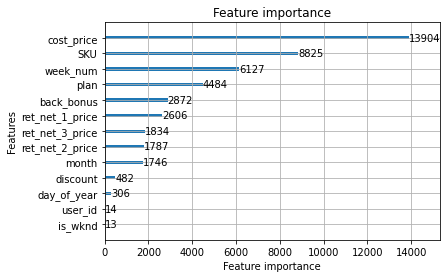

In [25]:
print('Plotting feature importances...')
ax = lgb.plot_importance(model, max_num_features=15)
plt.show()

In [26]:
UUID = '278a6454351246b696fd4a2bf5aec4d9'

URL_BEGIN_DATA = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/begin'
req = requests.post(URL_BEGIN_DATA.format(uuid=UUID))
print(req.json())
week_num_prev = 48

for i in range(31):
    print(f"number {i}")
        
    URL_TASK_DATA_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/data'
    response = requests.get(URL_TASK_DATA_GET.format(uuid=UUID))
    print(response)

    df = pd.read_json(response.json())
    df_ = df.copy()
    df_['dates'] = pd.to_datetime(df_['dates'])

    df_['year'] = df_.dates.dt.year
    df_['month'] = df_.dates.dt.month
    df_['week_num'] = df_.dates.dt.isocalendar().week.astype(int)

    if df_['week_num'][0] == 1:
        df_['week_num'] = 52
        print('NEW WEEK UPDATE')
        
    df_ = pd.merge(df_, df_wholesale_trade_table,
                   how='left', on=['SKU', 'year', 'month', 'week_num'])
    
    df_ = pd.merge(df_, df_promo,
                   how='left', on=['SKU', 'year', 'week_num'])

    df_ = pd.merge(df_, df_canc,
                   how='left', on=['SKU', 'year', 'week_num'])

    df_ = pd.merge(df_, df_sales,
                   how='left', on=['SKU', 'year', 'month'])

    df_ = date_to_datetime(df_)
    df_ = df_.drop(columns=['dates'])
    
    week_num_cur = df_['week_num'][0]
    
    print(f'week_num_prev {week_num_prev}')
    print(f'week_num_cur {week_num_cur}')
   
    if week_num_cur > week_num_prev:
        print('NEW MODEL')
        params = {
            'n_estimators': 1500,
            'max_depth': 10,
#             'num_leaves': 2**4,
            'learning_rate': 0.1
        }

        model = lgb.LGBMRegressor(first_metric_only = True, **params)

        Y_train = df_price_cost['price']
        X_train = df_price_cost.drop(columns=['price'])


        model.fit(X_train, Y_train,
                  verbose = 0)
        
        week_num_prev = df_['week_num'][0]

    else:
        print('OLD MODEL')
        
    X_test = df_
    forecast = model.predict(X_test)

    df['price'] = forecast
    df_['price'] = forecast
    
    df['price'] = df['price'] * 1.012
    
#         # Определите функцию, чтобы получить максимальную оценку каждого предмета
#     def get_min(row):
#         return min(row["ret_net_1_price"], row["ret_net_2_price"], row["ret_net_3_price"])

#     TEST = df_.copy()
#     TEST["minn"]=TEST.apply(lambda row:get_min(row),axis=1)

#     TEST['new_price'] = np.where(TEST['minn'] > TEST['price'], TEST['minn']-1, TEST['minn'] -1 )
#     TEST['new_price'] = TEST['new_price'].fillna(TEST['price'])
#     TEST = TEST.drop(columns=['minn', 'price'])
#     TEST = TEST.rename(columns={"new_price": "price"})
    
    URL_TASK_RESULT_POST = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result/'
    response_receive = requests.post(URL_TASK_RESULT_POST.format(uuid=UUID),
                                     data=df[['dates', 'SKU', 'user_id', 'price']].to_json(orient='records'))
    
    df_price_cost = pd.concat([df_price_cost, df_]).reset_index(drop=True)
    df_price_cost = df_price_cost.sort_values(
        by=['SKU', 'year', 'month', 'week_num'])
    
    print(response_receive.json()['status'])

#     break

{'status': 'ok'}
number 0
<Response [200]>
week_num_prev 48
week_num_cur 48
OLD MODEL
ok
number 1
<Response [200]>
week_num_prev 48
week_num_cur 49
NEW MODEL
ok
number 2
<Response [200]>
week_num_prev 49
week_num_cur 49
OLD MODEL
ok
number 3
<Response [200]>
week_num_prev 49
week_num_cur 49
OLD MODEL
ok
number 4
<Response [200]>
week_num_prev 49
week_num_cur 49
OLD MODEL
ok
number 5
<Response [200]>
week_num_prev 49
week_num_cur 49
OLD MODEL
ok
number 6
<Response [200]>
week_num_prev 49
week_num_cur 49
OLD MODEL
ok
number 7
<Response [200]>
week_num_prev 49
week_num_cur 49
OLD MODEL
ok
number 8
<Response [200]>
week_num_prev 49
week_num_cur 50
NEW MODEL
ok
number 9
<Response [200]>
week_num_prev 50
week_num_cur 50
OLD MODEL
ok
number 10
<Response [200]>
week_num_prev 50
week_num_cur 50
OLD MODEL
ok
number 11
<Response [200]>
week_num_prev 50
week_num_cur 50
OLD MODEL
ok
number 12
<Response [200]>
week_num_prev 50
week_num_cur 50
OLD MODEL
ok
number 13
<Response [200]>
week_num_prev 50


ValueError: Invalid file path or buffer object type: <class 'dict'>

In [33]:
def get_min(row):
    return min(row["ret_net_1_price"], row["ret_net_2_price"], row["ret_net_3_price"])

TEST = df_.copy()
TEST["minn"]=TEST.apply(lambda row:get_min(row),axis=1)
TEST

,SKU,user_id,year,month,week_num,cost_price,discount,ret_net_1_price,ret_net_2_price,ret_net_3_price,plan,back_bonus,quarter_of_year,day_of_year,is_wknd,price,minn
0,99974,27911,2019,12,52,2900.0,NaN,3369.132504,3343.880679,3370.393064,30.0,60000,4,364,0,3406.026112,3343.880679
1,18966,19421,2019,12,52,699.0,NaN,814.059981,823.329679,824.075265,210.0,200000,4,364,0,819.370344,814.059981
2,18966,38543,2019,12,52,699.0,NaN,814.059981,823.329679,824.075265,210.0,200000,4,364,0,819.370344,814.059981
3,33950,67654,2019,12,52,3709.0,NaN,NaN,NaN,NaN,110.0,160000,4,364,0,4319.422448,NaN
4,69577,70571,2019,12,52,232.0,NaN,270.651750,275.237786,270.289095,200.0,160000,4,364,0,289.015897,270.289095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9576,26819,40575,2019,12,52,1215.0,NaN,NaN,NaN,NaN,150.0,120000,4,364,0,1414.275417,NaN
9577,26819,37016,2019,12,52,1215.0,NaN,NaN,NaN,NaN,150.0,120000,4,364,0,1414.275417,NaN
9578,88782,20428,2019,12,52,2111.0,NaN,NaN,NaN,NaN,220.0,60000,4,364,0,2437.964013,NaN
9579,86653,42542,2019,12,52,950.0,NaN,1076.760137,1072.441730,1076.265270,130.0,40000,4,364,0,1101.259813,1072.441730


In [49]:
df

,dates,SKU,user_id,price
0,2019-12-30,99974,27911,3342.880679
1,2019-12-30,18966,19421,813.059981
2,2019-12-30,18966,38543,813.059981
3,2019-12-30,33950,67654,4319.422448
4,2019-12-30,69577,70571,269.289095
...,...,...,...,...
9576,2019-12-30,26819,40575,1414.275417
9577,2019-12-30,26819,37016,1414.275417
9578,2019-12-30,88782,20428,2437.964013
9579,2019-12-30,86653,42542,1071.441730


In [50]:
# Определите функцию, чтобы получить максимальную оценку каждого предмета
def get_min(row):
    return min(row["ret_net_1_price"], row["ret_net_2_price"], row["ret_net_3_price"])

TEST = df.copy()
# TEST['|price'] = TEST['price'] * 1.012
TEST["minn"]=TEST.apply(lambda row:get_min(row),axis=1)

TEST['new_price'] = np.where(TEST['minn'] > TEST['price'], TEST['minn']- 0.1, TEST['minn'] - 0.1 )
TEST['new_price'] = TEST['new_price'].fillna(TEST['price'])
TEST = TEST.drop(columns=['minn', 'price'])
TEST = TEST.rename(columns={"new_price": "price"})
TEST

KeyError: 'ret_net_1_price'

In [163]:
df['price'] = TEST['price']
df

,dates,SKU,user_id,price
0,2019-12-01,16019,24550,1141.478466
1,2019-12-01,84011,41305,4485.624859
2,2019-12-01,84011,39080,4485.624859
3,2019-12-01,29011,30308,2547.060053
4,2019-12-01,79558,44541,2863.520083
...,...,...,...,...
9735,2019-12-01,45404,45187,2824.081887
9736,2019-12-01,46933,11426,2015.291002
9737,2019-12-01,46933,38904,2015.291002
9738,2019-12-01,46933,44894,2015.291002


In [ ]:
df_price_cost

In [23]:
print(response.json()['status'])

batch processing finished


In [55]:
URL_TASK_RESULT_GET = 'https://lab.karpov.courses/hardml-api/project-1/task/{uuid}/result'
response = requests.get(URL_TASK_RESULT_GET.format(uuid=UUID))

# Чтобы перевести полученный ответ в pd.DataFrame
df = pd.read_json(response.json())
df.head()

,dates,SKU,user_id,price,bought
0,2019-12-01,16019,25554,1141.478466,0
1,2019-12-01,84011,39598,4496.256470,1
2,2019-12-01,84011,30248,4496.256470,1
3,2019-12-01,29011,18405,2536.921464,1
4,2019-12-01,79558,28374,2863.424758,0


In [58]:
df_1 = df[df['bought'] == 1]
df_1.head()

,dates,SKU,user_id,price,bought
0,2019-12-01,16019,32813,1040.411870,1
6,2019-12-01,86541,33723,2712.497225,1
8,2019-12-01,46933,47630,1877.036381,1
9,2019-12-01,46933,15774,1877.036381,1
13,2019-12-01,41955,11117,2997.356091,1


In [59]:
len(df_1.SKU.unique())

826

In [66]:
df_1[df_1['SKU'] == 86541]

,dates,SKU,user_id,price,bought
6,2019-12-01,86541,33723,2712.497225,1
691,2019-12-01,86541,12863,2712.497225,1
693,2019-12-01,86541,22311,2712.497225,1
2425,2019-12-01,86541,32259,2712.497225,1
3462,2019-12-01,86541,45202,2712.497225,1
...,...,...,...,...,...
284291,2019-12-30,86541,41127,2708.882155,1
287469,2019-12-30,86541,46909,2708.882155,1
287480,2019-12-30,86541,14479,2708.882155,1
287490,2019-12-30,86541,38135,2708.882155,1


In [67]:
df_0[df_0['SKU'] == 86541]

,dates,SKU,user_id,price,bought
5,2019-12-01,86541,30649,2712.497225,0
692,2019-12-01,86541,91116,2712.497225,0
2085,2019-12-01,86541,49475,2712.497225,0
7666,2019-12-01,86541,44093,2712.497225,0
9017,2019-12-01,86541,38612,2712.497225,0
...,...,...,...,...,...
283418,2019-12-30,86541,29869,2708.882155,0
283425,2019-12-30,86541,39397,2708.882155,0
284279,2019-12-30,86541,33960,2708.882155,0
284340,2019-12-30,86541,36919,2708.882155,0


In [60]:
df_0 = df[df['bought'] == 0]
df_0.head()

,dates,SKU,user_id,price,bought
1,2019-12-01,84011,55841,4062.875107,0
2,2019-12-01,84011,16345,4062.875107,0
3,2019-12-01,29011,12544,2268.398158,0
4,2019-12-01,79558,49751,2577.125468,0
5,2019-12-01,86541,30649,2712.497225,0


In [61]:
len(df_0.SKU.unique())

826

In [62]:
df_0.price.sum()

358676192.4784469

In [63]:
df_1.price.sum()

257251407.59074932

In [ ]:
266.710.705